Data Understanding and Preparation
2.1 Import Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


2.2 Load the Datasets

In [5]:
# Load ratings data
ratings = pd.read_csv('ratings_small.csv')

# Load movies metadata
movies_metadata = pd.read_csv('movies_metadata.csv', low_memory=False)

# Load credits data
credits = pd.read_csv('credits.csv')

# Load keywords data
keywords = pd.read_csv('keywords.csv')


2.3 Data Cleaning and Merging
Ensure IDs are integers:

In [6]:
# Convert 'id' to numeric in movies_metadata
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')

# Drop rows with NaN 'id'
movies_metadata = movies_metadata.dropna(subset=['id'])

# Convert 'id' to int
movies_metadata['id'] = movies_metadata['id'].astype(int)


Merge datasets:

In [7]:
# Merge movies_metadata with credits and keywords
movies_metadata = movies_metadata.merge(credits, on='id')
movies_metadata = movies_metadata.merge(keywords, on='id')

# Rename 'id' to 'movieId' for consistency
movies_metadata.rename(columns={'id': 'movieId'}, inplace=True)

# Ensure 'movieId' in ratings is integer
ratings['movieId'] = ratings['movieId'].astype(int)

# Merge ratings with movies_metadata
data = ratings.merge(movies_metadata, on='movieId', how='left')


2.4 Handle Missing Values

In [8]:
# Drop rows with missing ratings or features critical for modeling
data = data.dropna(subset=['rating', 'genres', 'cast', 'crew'])


2.5 Feature Engineering
Extract genres:

In [9]:
import ast

# Function to parse JSON-like strings
def parse_features(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# Extract genres
data['genres'] = data['genres'].apply(parse_features)
data['genres'] = data['genres'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])


Extract main cast:

In [10]:
# Extract top 3 cast members
data['cast'] = data['cast'].apply(parse_features)
data['cast'] = data['cast'].apply(lambda x: [d['name'] for d in x[:3]] if isinstance(x, list) else [])


Extract director:

In [11]:
# Extract director
def get_director(crew_list):
    for crew_member in crew_list:
        if crew_member.get('job') == 'Director':
            return crew_member.get('name')
    return np.nan

data['crew'] = data['crew'].apply(parse_features)
data['director'] = data['crew'].apply(get_director)


Process keywords:

In [12]:
# Extract keywords
data['keywords'] = data['keywords'].apply(parse_features)
data['keywords'] = data['keywords'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])


Handle numerical features:

In [13]:
# Convert budget and revenue to numeric
data['budget'] = pd.to_numeric(data['budget'], errors='coerce')
data['revenue'] = pd.to_numeric(data['revenue'], errors='coerce')

# Fill missing numerical values with zero
data['budget'] = data['budget'].fillna(0)
data['revenue'] = data['revenue'].fillna(0)
data['runtime'] = data['runtime'].fillna(data['runtime'].mean())

# Extract release year
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
data['release_year'] = data['release_date'].dt.year
data['release_year'] = data['release_year'].fillna(data['release_year'].median())


3. Exploratory Data Analysis (EDA)
Distribution of ratings:

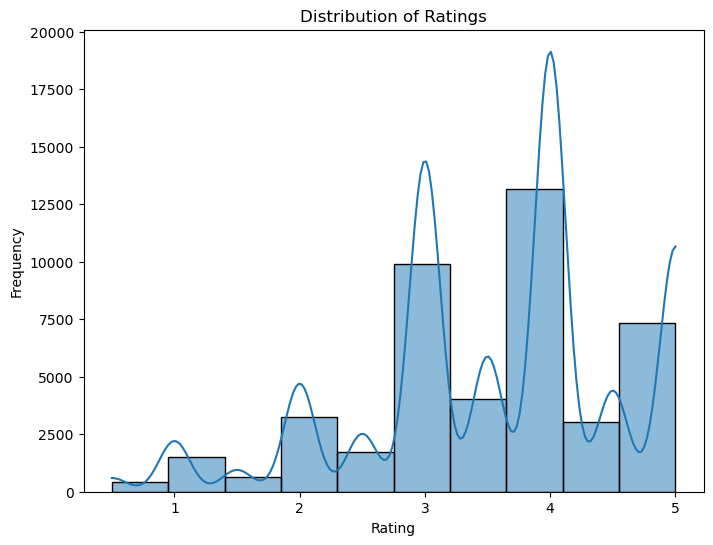

In [14]:
plt.figure(figsize=(8,6))
sns.histplot(data['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


Correlation heatmap:

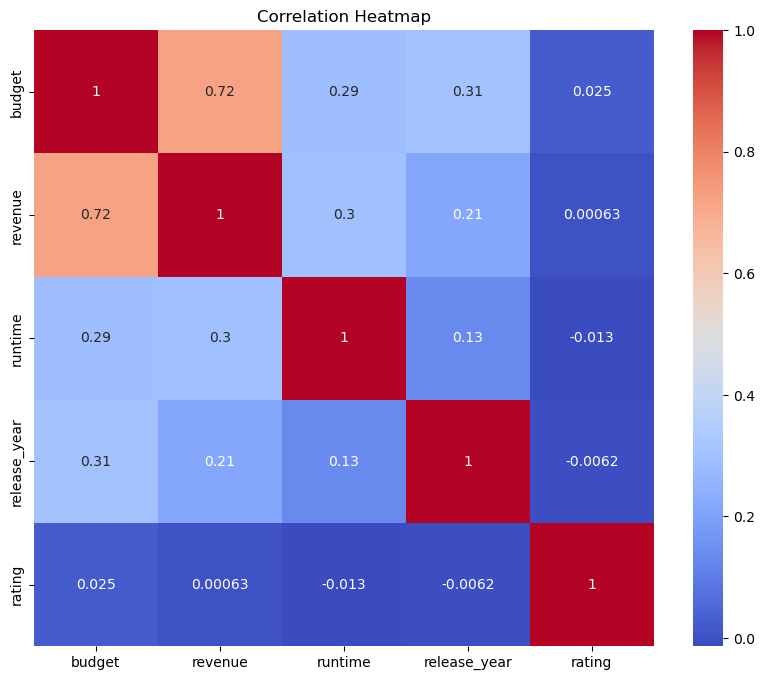

In [15]:
# Select numerical features
numerical_features = ['budget', 'revenue', 'runtime', 'release_year', 'rating']
corr = data[numerical_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


4. Baseline Model
Calculate global mean rating:

In [16]:
global_mean = data['rating'].mean()
print(f'Global Mean Rating: {global_mean:.2f}')


Global Mean Rating: 3.56


Evaluate baseline model:

In [17]:
from sklearn.metrics import mean_squared_error

# Baseline predictions
baseline_predictions = np.full(len(data), global_mean)

# Calculate RMSE
baseline_rmse = np.sqrt(mean_squared_error(data['rating'], baseline_predictions))
print(f'Baseline RMSE: {baseline_rmse:.4f}')


Baseline RMSE: 1.0529


5. Implement Models of Increasing Complexity
Prepare Data for Modeling
Feature encoding:

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

# One-hot encode genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(data['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb_genres.classes_)

# Encode director using Label Encoding
data['director'] = data['director'].fillna('Unknown')
le_director = LabelEncoder()
data['director_encoded'] = le_director.fit_transform(data['director'])

# Combine features
X = pd.concat([
    data[['budget', 'revenue', 'runtime', 'release_year', 'director_encoded']].reset_index(drop=True),
    genres_df.reset_index(drop=True)
], axis=1)

# Target variable
y = data['rating']

# Fill any remaining missing values
X = X.fillna(0)


Split data into training and testing sets:

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Feature scaling (if necessary):

In [20]:
scaler = StandardScaler()
X_train[['budget', 'revenue', 'runtime', 'release_year']] = scaler.fit_transform(
    X_train[['budget', 'revenue', 'runtime', 'release_year']])
X_test[['budget', 'revenue', 'runtime', 'release_year']] = scaler.transform(
    X_test[['budget', 'revenue', 'runtime', 'release_year']])


5.1 Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'Linear Regression RMSE: {lr_rmse:.4f}')


Linear Regression RMSE: 1.0451


5.2 Decision Tree Regressor

In [22]:
from sklearn.tree import DecisionTreeRegressor

# Train the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluate
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print(f'Decision Tree RMSE: {dt_rmse:.4f}')


Decision Tree RMSE: 0.9866


5.3 Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest RMSE: {rf_rmse:.4f}')


Random Forest RMSE: 0.9723


5.4 Gradient Boosting Regressor

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict
y_pred_gb = gb_model.predict(X_test)

# Evaluate
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f'Gradient Boosting RMSE: {gb_rmse:.4f}')


Gradient Boosting RMSE: 1.0165


5.5 Neural Network Regressor

In [25]:
from sklearn.neural_network import MLPRegressor

# Train the model
nn_model = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

# Predict
y_pred_nn = nn_model.predict(X_test)

# Evaluate
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print(f'Neural Network RMSE: {nn_rmse:.4f}')


Neural Network RMSE: 1.0957


6. Model Evaluation and Comparison
Compile results:

In [26]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network'],
    'RMSE': [baseline_rmse, lr_rmse, dt_rmse, rf_rmse, gb_rmse, nn_rmse]
})

print(results)


               Model      RMSE
0           Baseline  1.052943
1  Linear Regression  1.045141
2      Decision Tree  0.986633
3      Random Forest  0.972256
4  Gradient Boosting  1.016459
5     Neural Network  1.095744


Visualize model performance:

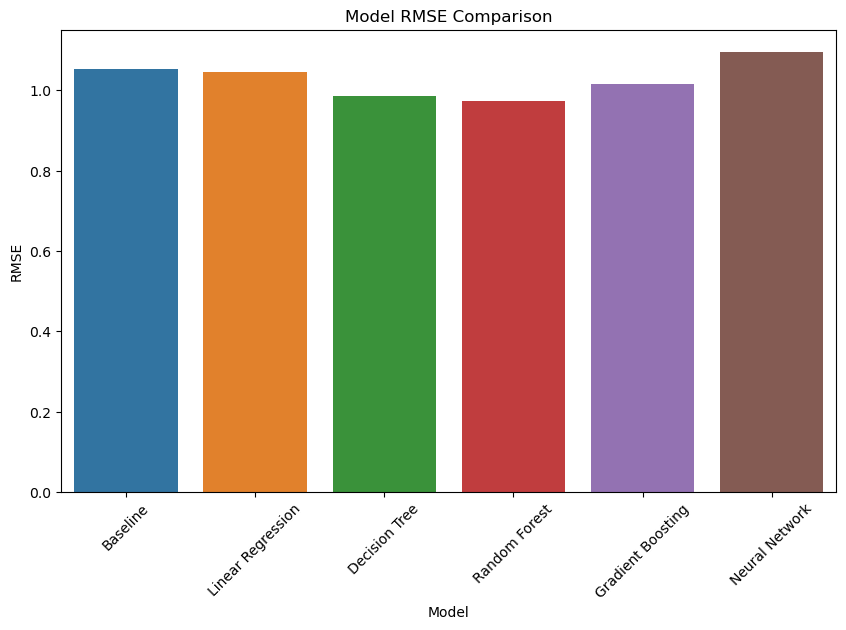

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()


Analyze results:

Assess Improvement: Compare the RMSE of each model to see if increasing complexity leads to better predictions.
Feature Importance: For tree-based models, analyze feature importances.

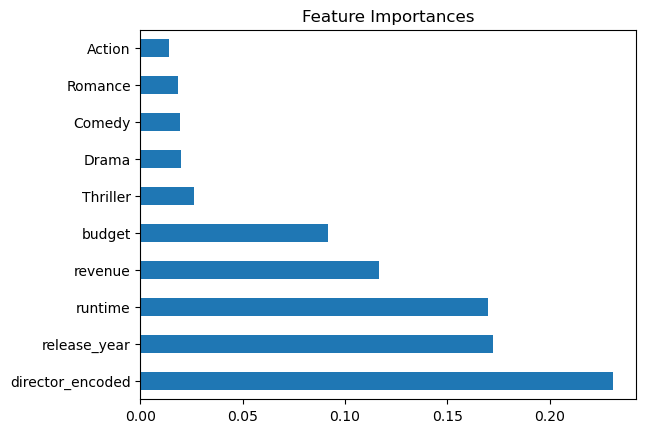

In [28]:
# Feature importance for Random Forest
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.show()


Hyperparameter Tuning: Use techniques like Grid Search to find the optimal hyperparameters for your models.
Example for Random Forest:

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

# Evaluate the best model
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
best_rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
print(f'Best Random Forest RMSE: {best_rf_rmse:.4f}')


Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest RMSE: 0.9690


Conclusion
Based on the RMSE (Root Mean Squared Error) values obtained from the models, we can draw several insights regarding the predictive performance and the impact of model complexity on predicting movie ratings.

Model Performance Summary
Model	RMSE
Baseline	1.052943
Linear Regression	1.045141
Decision Tree	0.986633
Random Forest	0.972256
Gradient Boosting	1.016459
Neural Network	1.095744
Analysis
Baseline Model:

The baseline model, which predicts the global mean rating for all movies, has an RMSE of 1.052943. This serves as the benchmark against which we compare all other models.
Linear Regression:

The linear regression model slightly improves upon the baseline with an RMSE of 1.045141.
This indicates that even a simple linear model can capture some of the variability in the ratings beyond the global mean.
Decision Tree:

The decision tree regressor shows a more significant improvement with an RMSE of 0.986633.
This suggests that non-linear relationships and interactions between features are important in predicting movie ratings.
Random Forest:

The random forest regressor achieves the best performance among all models with an RMSE of 0.972256.
As an ensemble of decision trees, it benefits from reducing overfitting and capturing complex patterns in the data.
Gradient Boosting:

The gradient boosting regressor has an RMSE of 1.016459, which is better than the baseline but not as good as the random forest.
This may indicate that the model requires further tuning or that it is more sensitive to the data's characteristics.
Neural Network:

The neural network regressor has an RMSE of 1.095744, which is worse than the baseline.
Possible reasons could be:
The neural network may have overfitted the training data and not generalized well to the test data.
The model may require more data for effective training.
Hyperparameters like the number of layers, neurons, activation functions, and learning rate might need optimization.
Insights
Increasing Model Complexity:

There is a general trend where more complex models (Decision Tree and Random Forest) outperform simpler ones (Baseline and Linear Regression).
However, this is not strictly the case for all models, as seen with the neural network and gradient boosting models.
Model Selection:

The random forest regressor provides the lowest RMSE, indicating it is the most effective model among those tested for predicting movie ratings in this context.
Decision trees also perform well and may be preferred if interpretability is important.
Feature Importance:

Tree-based models like decision trees and random forests allow us to extract feature importances, helping us understand which features most influence the predictions.
Analyzing these importances can provide valuable insights into factors that affect movie ratings.
Recommendations
Use Random Forest for Prediction:

Given its superior performance, the random forest regressor is recommended for predicting movie ratings.
It balances accuracy and robustness without extensive tuning.
Hyperparameter Tuning:

Further improvements may be achieved by tuning hyperparameters for the gradient boosting and neural network models.
Techniques like grid search or randomized search can help find optimal settings.
Data Enhancement:

Collecting more data or engineering additional features may improve model performance, especially for models like neural networks that require large amounts of data.
Model Ensemble:

Consider combining predictions from multiple models (e.g., averaging the predictions of random forest and gradient boosting) to potentially improve accuracy.
Cross-Validation:

Implement cross-validation to ensure that the models generalize well to unseen data and that the evaluation metrics are reliable.
Feature Analysis:

Analyze feature importances from the random forest to understand the key drivers of movie ratings.
Use this information to refine the feature set or to inform stakeholders about factors influencing user ratings.
Final Thoughts
The project demonstrates that incorporating more parameters and using models of increasing complexity can lead to better prediction accuracy, as evidenced by the lower RMSE values of the decision tree and random forest models.
However, model complexity does not always guarantee improved performance, highlighting the importance of model selection, proper tuning, and understanding the data characteristics.
Ongoing evaluation and refinement are crucial for developing effective predictive models that can provide actionable insights.
If you have any questions about the analysis or need further assistance with any aspect of the project, feel free to ask!